# Medical-MNIST CNN

Example of classifying medical mnsit images with TensorFlow

Download the data from https://www.kaggle.com/andrewmvd/medical-mnist. First, click "Download (80 MB)". Sign in with a prefered email and download the zip file. Then uncompress it to `kaggle-medical-mnist/archive` in the project data folder.

Some of the commented code is to allow change to different classes (or add them all to the model).

code from https://www.kaggle.com/sarimsikander/medical-mnist-cnn-99-96-accuracy

#### Included MIA example at the end
Membership inference attacks on TensorFlow require the TensorFlow-Privacy library, available on PyPi:
`pip install tensorflow-privacy`

In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm  
import cv2
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Imports for MIA
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from scipy import special

%matplotlib inline

In [8]:
ROOT_DIR = '../../../../../../research'
DATA_FOLDER = os.path.join(
    ROOT_DIR,
    'data',
    'kaggle-medical-mnist',
    'archive'
)

In [9]:
#classes = {'AbdomenCT': 0, 'BreastMRI': 1, 'ChestCT': 2, 'CXR': 3, 'Hand': 4, 'HeadCT': 5}
classes = {'AbdomenCT': 0, 'ChestCT': 1}

In [10]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 64
N_CLASSES = 2  # 6 # Change this according to the number of classes, which can be up to 6 in this example (6 types of images available)
EPOCHS = 1 # 5 5 was set when all the classes where used

In [11]:
abdomen_DIR = os.path.join(DATA_FOLDER, 'AbdomenCT') 
#breastmri_DIR = os.path.join(DATA_FOLDER, 'BreastMRI''
chestct_DIR = os.path.join(DATA_FOLDER, 'ChestCT')
#cxr_DIR = os.path.join(DATA_FOLDER, 'CXR')
#hand_DIR = os.path.join(DATA_FOLDER, 'Hand')
#headct = os.path.join(DATA_FOLDER,DATA_FOLDER 'HeadCT')

In [12]:
def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    #print(DIR)
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

In [13]:
make_train_data(classes.get('AbdomenCT'), abdomen_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:10<00:00, 16.39it/s]


In [14]:
#make_train_data(classes.get('BreastMRI'), breastmri_DIR)

In [15]:
make_train_data(classes.get('ChestCT'), chestct_DIR)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 475.60it/s]


In [16]:
#make_train_data(classes.get('CXR'), cxr_DIR)

In [17]:
#make_train_data(classes.get('Hand'), hand_DIR)

In [18]:
#make_train_data(classes.get('HeadCT'), headct)

In [28]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(20000, 64, 64, 3)

In [20]:
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=58954)

In [21]:
k = len(set(y_train))
print("Number of classes, ", k)

Number of classes,  2


In [22]:
X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

In [23]:
y_train = to_categorical(y_train, num_classes=k)
y_test = to_categorical(y_test, num_classes=k)

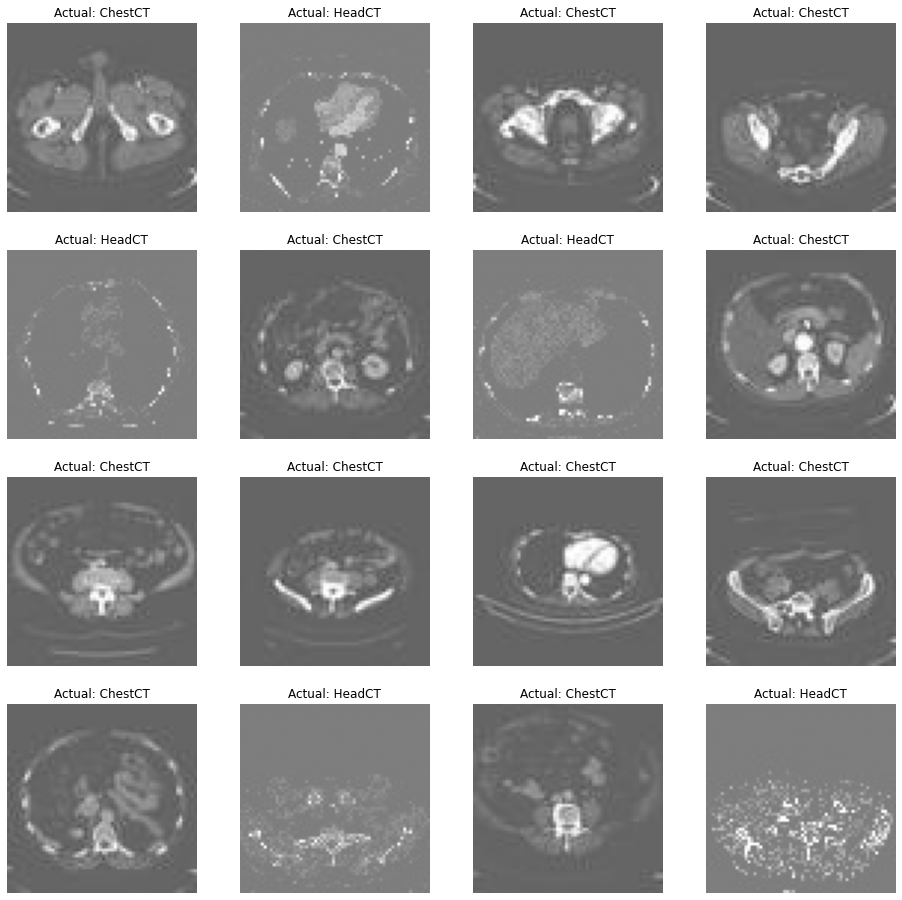

In [24]:
labels = '''ChestCT
HeadCT'''.split("\n")

#labels = '''AbdomenCT
#BreastMRI
#ChestCT
#CXR
#Hand
#HeadCT'''.split("\n")


plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,1000,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))


*Here I introduce a couple of small changes:*
TF-Privacy MIA implementation requires both the logits and the output probabilities of the model, so I remove the activation function from the last layer.

In [25]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(i)
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(k, activation='softmax')(x)
x = layers.Dense(k)(x)


model = Model(i, x)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

Now, the losses have to be computed from the logits instead of from the probabilities.

In [27]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#               loss='categorical_crossentropy', metrics=['accuracy'])
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=loss, metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data=  (X_test,y_test), callbacks=[reduce_lr])

282/282 [==============================] - 7s 6ms/step - loss: 0.0956 - accuracy: 0.9553 - val_loss: 2.7400e-04 - val_accuracy: 1.0000 - lr: 0.0010


In [28]:
reduce_lr

The class of this is: 1


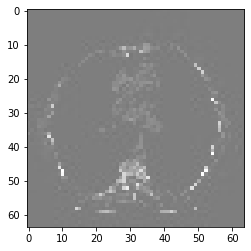

In [29]:
print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()

Confusion matrix, without normalization
[[ 992    0]
 [   0 1008]]


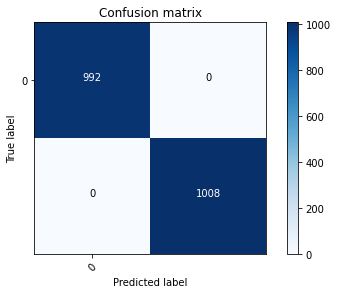

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(k-1)))

In [31]:
misclassified_idx = np.where(p_test != np.argmax(y_test, axis= 1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[np.argmax(y_test[i])], labels[p_test[i]]));

ValueError: 'a' cannot be empty unless no samples are taken

## Membership inference attack using TF-Privacy
The inputs to the function are the train and test features and labels, along with the trained model.

The function internally computes the probabilities from the logits, using the softmax function.

`SlicingSpec` configures how the data is used to run the attacks. In the example below, the attacks will be performed on the whole dataset, on individual classes, and on correctly/incorrectly classified instances. 
`attack_types` tells the engine what type of MIA are to be run: for example, the threshold attack works on the assumption that the classification loss for member instances will be smaller than that of the non-member instances. The MLP attack builds shadow models as the Shokri attack.

In [31]:
def membership_inference_attack(model, batch_size, X_train, X_test, y_train, y_test):
    print('Predict on train...')
    logits_train = model.predict(X_train, batch_size=batch_size)
    print('Predict on test...')
    logits_test = model.predict(X_test, batch_size=batch_size)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    print('Compute losses...')
    cce = tf.keras.backend.categorical_crossentropy
    constant = tf.keras.backend.constant

    loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
    loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()
    
    labels_train = np.argmax(y_train, axis=1)
    labels_test = np.argmax(y_test, axis=1)

    input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = labels_train,
      labels_test = labels_test
    )

    # Run several attacks for different data slices
    attacks_result = mia.run_attacks(input,
                                     SlicingSpec(
                                         entire_dataset = True,
                                         by_class = True,
                                         by_classification_correctness = True
                                     ),
                                     attack_types = [
                                         AttackType.THRESHOLD_ATTACK,
                                         AttackType.LOGISTIC_REGRESSION,
                                         AttackType.MULTI_LAYERED_PERCEPTRON,
                                         AttackType.RANDOM_FOREST, 
                                         AttackType.K_NEAREST_NEIGHBORS,
                                         AttackType.THRESHOLD_ENTROPY_ATTACK
                                     ])

    # Plot the ROC curve of the best classifier
    fig = plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

    # Print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices = True))
    return attacks_result.get_result_with_max_auc().get_auc(), attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

The report shows the ROC for the best performing attack. Here, an AUC of 0.5 means random guessing, so no success at all.
The attack advantage is normalized to the interval 0-1, and equals max(|tpr-fpr|)

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 2000 training and 2000 test examples) achieved an AUC of 0.53 on slice Entire dataset
  LOGISTIC_REGRESSION (with 992 training and 992 test examples) achieved an advantage of 0.13 on slice CLASS=0

Best-performing attacks over slice: "Entire dataset"
  MULTI_LAYERED_PERCEPTRON (with 2000 training and 2000 test examples) achieved an AUC of 0.53
  MULTI_LAYERED_PERCEPTRON (with 2000 training and 2000 test examples) achieved an advantage of 0.08

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 992 training and 992 test examples) achieved an AUC of 0.52
  LOGISTIC_REGRESSION (with 992 training and 992 test examples) achieved an advantage of 0.13

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1008 training and 1008 test examples) achieved an AUC of 0.51
  

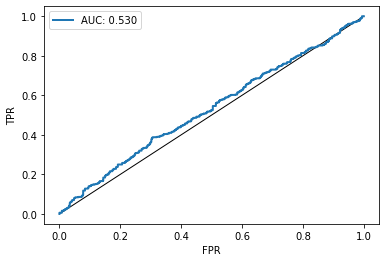

In [33]:
auc, adv = membership_inference_attack(model, BATCH_SIZE, X_train, X_test, y_train, y_test)